# Directional Modelling
### Author: Johnny Barrett

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
from plot_tools import px_density, theme
pd.options.plotting.backend = 'plotly'
px.defaults.template = 'plotly_dark'
px.defaults.height = 650
px.defaults.width = 1000

plasma = px.colors.sequential.Plasma
plasma_cyc1 = plasma[1:] + plasma[::-1][1:-1]
plasma_cyc2 = plasma[1:-1] + plasma[::-1][2:-1]

In [2]:
def show(plot, h=650, w=1000):
    plot = theme(plot)
    plot.show(height=h, width=w, renderer='png')

In [3]:
df = pd.read_csv('../ocean-waves-full.csv', parse_dates=['DateTime'])

In [4]:
SEASONS = ['Summer','Autumn','Winter','Spring']

def month_to_season(month, name=False):
    season_num = (month%12 + 3) // 3
    if name:
        return SEASONS[season_num - 1]
    else:
        return season_num
    
df['Season'] = df['Month'].apply(month_to_season, name=True).astype('category')
df['Season'].cat.set_categories(SEASONS, ordered=True, inplace=True)
df['SeasonNum'] = df['Month'].apply(month_to_season, name=False)

# 1  EDA

In [5]:
dt_range = pd.date_range(min(df['DateTime']), max(df['DateTime']), freq='30min')
time_df = df.set_index('DateTime').reindex(index=dt_range)

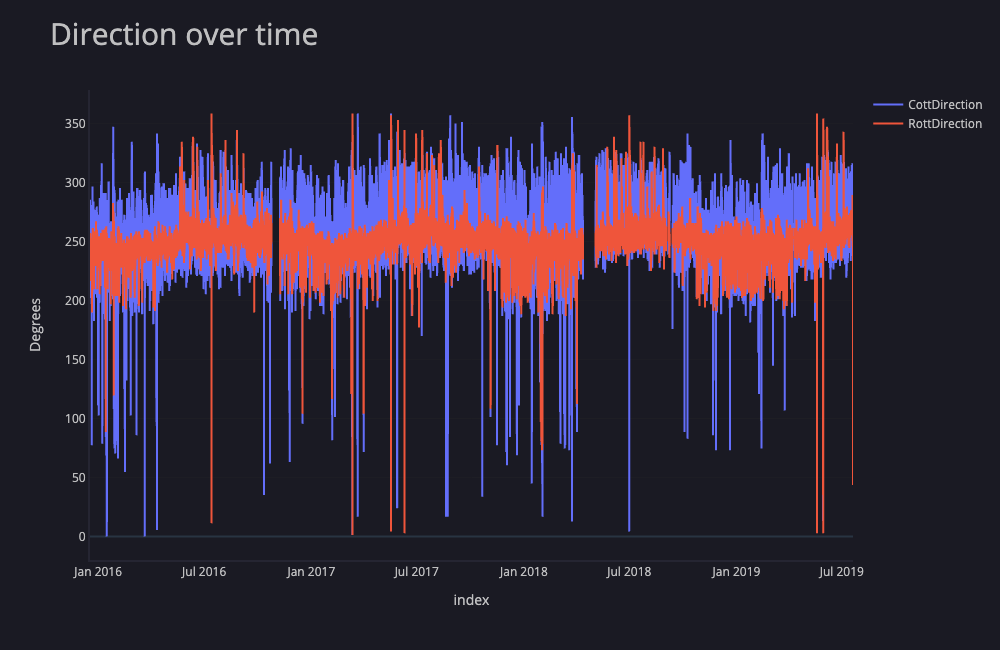

In [15]:
p1 = theme(px.line(time_df, y=['CottDirection','RottDirection'],
                   labels={'variable':'', 'value': 'Degrees'},
                   title='Direction over time'))
show(p1)

#### Zooming on one date range
<img src="img/dir-time-zoomed.png" style='max-width: 1000px'>

## 1.2  Relationship with other variables

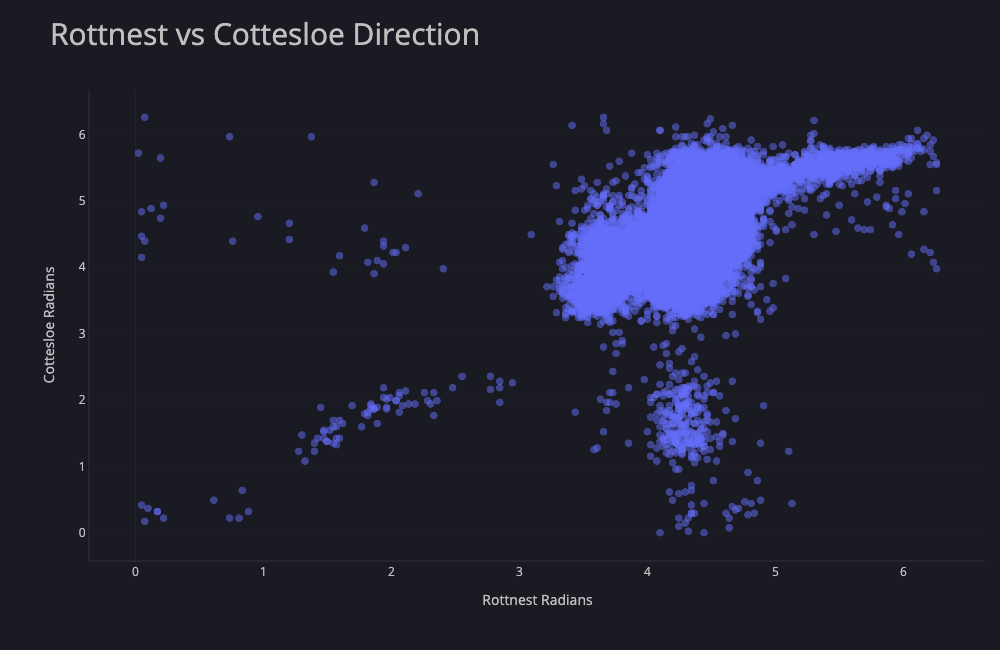

In [545]:
p2 = px.scatter(df, 'RottRad', 'CottRad', opacity=0.5,
                title='Rottnest vs Cottesloe Direction',
                labels={'CottRad': 'Cottesloe Radians', 'RottRad': 'Rottnest Radians'})
p2 = theme(p2).update_yaxes(zeroline=False).update_layout(coloraxis_showscale=False)
show(p2)

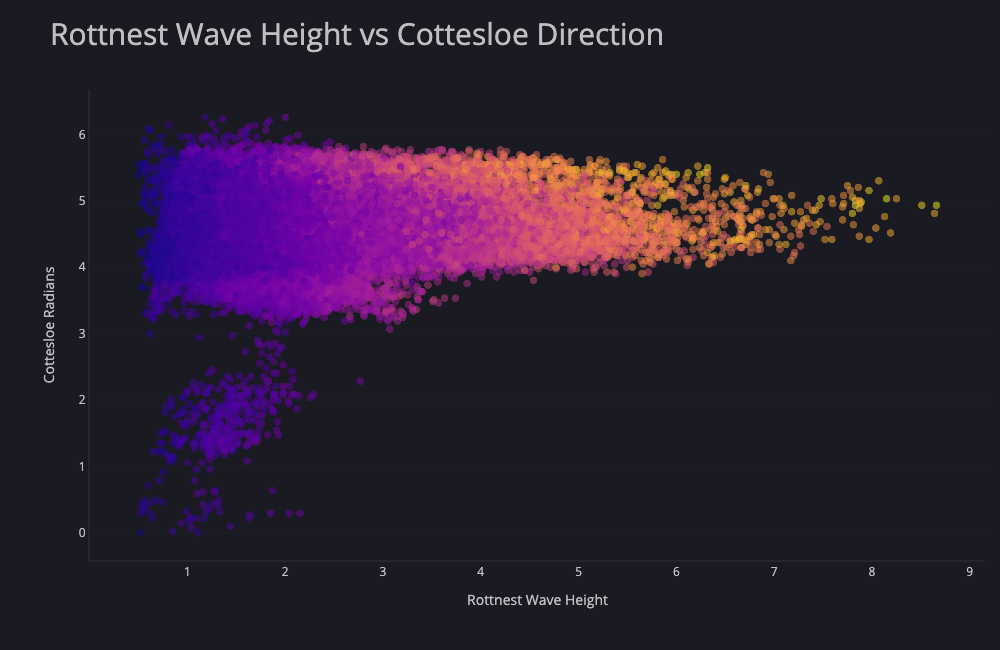

In [19]:
p3 = px.scatter(df, 'RottHeight', 'CottRad', color='CottHeight', opacity=0.5,
                title='Rottnest Wave Height vs Cottesloe Direction',
                labels={'CottRad': 'Cottesloe Radians', 'RottHeight': 'Rottnest Wave Height'})
p3 = theme(p3).update_yaxes(zeroline=False).update_layout(coloraxis_showscale=False)
show(p3)

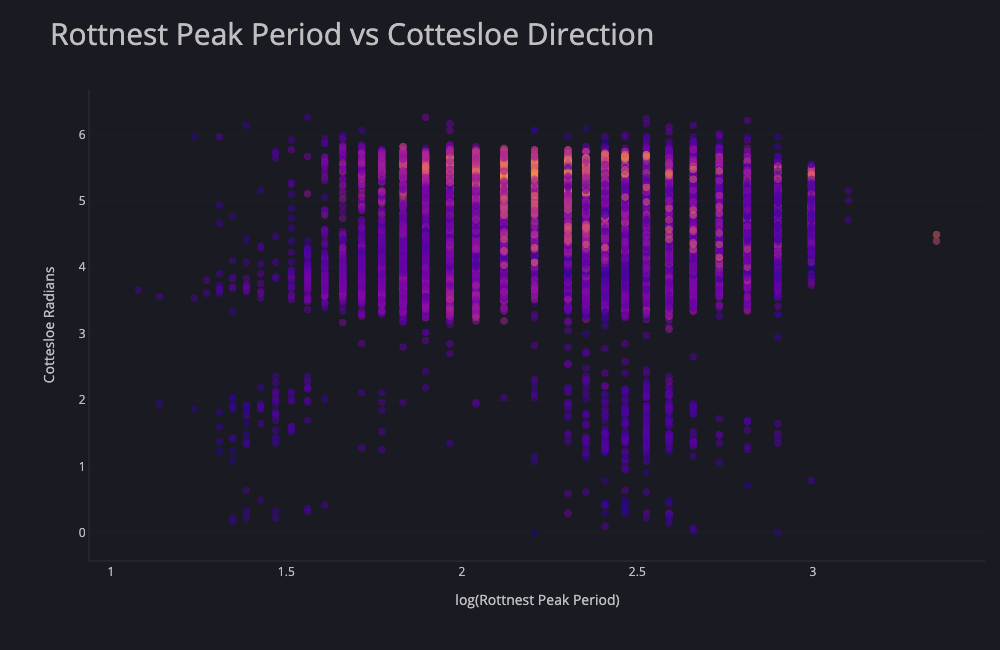

In [25]:
p4 = px.scatter(df, np.log(df['RottPeakPeriod']), 'CottRad', color='CottHeight', opacity=0.5,
                title='Rottnest Peak Period vs Cottesloe Direction',
                labels={'CottRad': 'Cottesloe Radians', 'x': 'log(Rottnest Peak Period)'})
p4 = theme(p4).update_yaxes(zeroline=False).update_layout(coloraxis_showscale=False)
show(p4)

In [144]:
mnth_med = df.groupby('Month')['CottRad'].median()

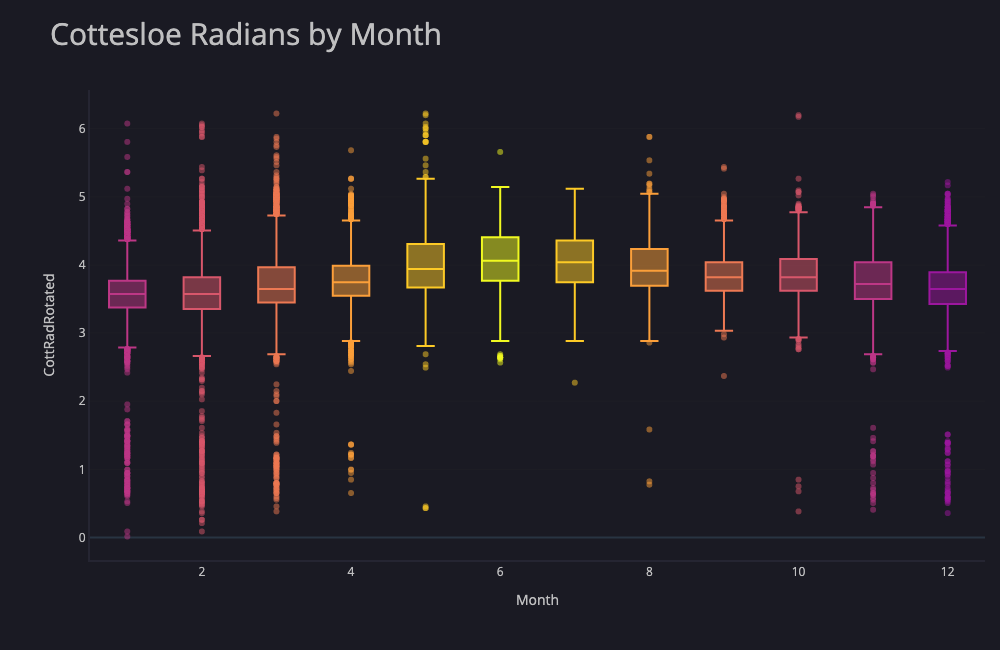

In [548]:
p8 = px.box(df, 'Month', 'CottRadRotated', color='Month', color_discrete_sequence=plasma_cyc1[3:16],
            category_orders=dict(Month=list(range(1,13))), title='Cottesloe Radians by Month')\
                .update_layout(showlegend=False).update_traces(marker_opacity=0.5)
show(theme(p8))

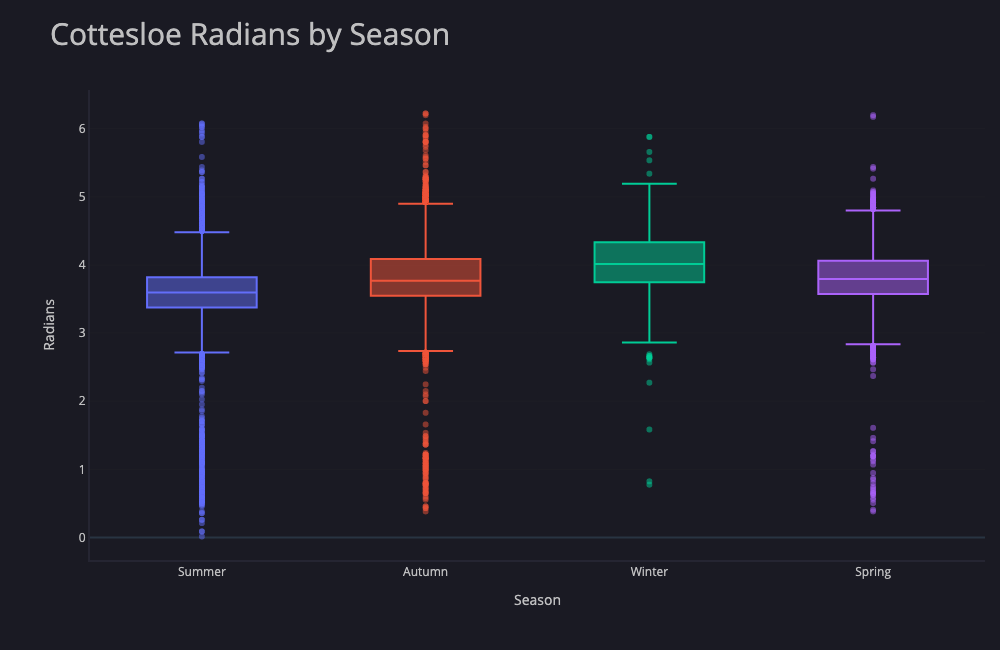

In [550]:
p9 = px.box(df, 'Season', 'CottRadRotated', color='Season', title='Cottesloe Radians by Season',
            labels={'CottRadRotated': 'Radians'})\
                .update_layout(showlegend=False).update_traces(marker_opacity=0.5)
show(theme(p9))

In [25]:
tmp = []
for season in SEASONS:
    tmp.append(df.query('Season == @season')['CottRad'])
ssn_df = pd.concat(tmp, axis=1)
ssn_df.columns = SEASONS

In [201]:
kde = ff.create_distplot(
    [df.query('Season == @season')['CottRad'] for season in SEASONS],
    group_labels=SEASONS, show_hist=False, show_rug=False)

p10 = px.area(title='Cottesloe Direction by Season')
for i, var in enumerate(SEASONS):
    p10.add_scatter(mode='lines', x=kde.data[i]['x'], y=kde.data[i]['y'],
                    name=SEASONS[i], fill='tozeroy')  #,line_color=plasma_cyc[1::4][i])

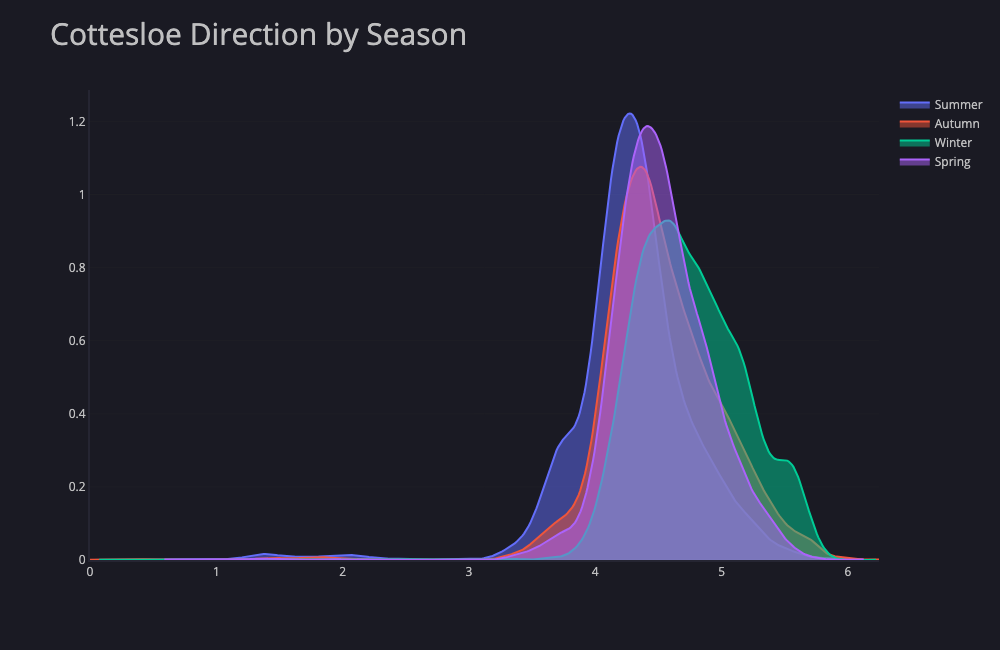

In [202]:
show(theme(p10))

___
# 2 Circular statistics and modelling

In [28]:
import astropy
import astropy.stats.circstats as circstats

##  2.1  Summary statistics

In [244]:
deg_to_rad = lambda deg: deg * np.pi / 180
rad_to_deg = lambda rad: rad / np.pi * 180

In [307]:
def circ_mean_var(circ, return_deg=False):

    s_bar = np.sum(np.sin(circ))
    c_bar = np.sum(np.cos(circ))
    arctan = np.arctan(s_bar/c_bar)
    R = np.sqrt(c_bar**2 + s_bar**2)
    
    if c_bar >= 0:
        circ_bar = arctan
    elif c_bar < 0:
        circ_bar = arctan + np.pi
    elif R == 0:
        print('Undefined')
        circ_bar = np.nan
    
    circ_var = 1 - (R / len(circ))
    unit = 'rad'
    
    if return_deg:  # return degrees
        unit = 'deg'
        circ_bar = rad_to_deg(circ_bar)
        circ_var = rad_to_deg(circ_var)
        
    print(f'Circular mean:     {round(circ_bar, 4)} {unit}')
    print(f'Circular variance: {round(circ_var, 4)} {unit}')
    return circ_bar, circ_var

#### Cottesloe

In [352]:
cott_mean, cott_var = circ_mean_var(df['CottRad'])

Circular mean:     4.5253 rad
Circular variance: 0.1007 rad


In [316]:
_ = circ_mean_var(df['CottRad'], return_deg=True)

Circular mean:     259.2785 deg
Circular variance: 5.7698 deg


#### Rottnest

In [353]:
rott_mean, rott_var = circ_mean_var(df['RottRad'])

Circular mean:     4.3653 rad
Circular variance: 0.0341 rad


In [312]:
_ = circ_mean_var(df['RottRad'], return_deg=True)

Circular mean:     250.1113 deg
Circular variance: 1.9536 deg


## 2.2  Coefficients

In [30]:
def linear_circ_corr(lin, circ):
    rxc = lin.corr(np.cos(circ))
    rxs = lin.corr(np.sin(circ))
    rcs = np.cos(circ).corr(np.sin(circ))
    return (rxc**2 + rxs**2 - 2*rxc*rxs*rcs) / (1 - rcs**2)

In [66]:
def circ_season(season_num):
    return season_num * (2*np.pi / 4)

def circ_month(date):
    return date.month * (2*np.pi / 12)

In [67]:
df['circSeason'] = df['SeasonNum'].apply(circ_season)
df['circMonth'] = df['DateTime'].apply(circ_month)

### Cottesloe and Rottnest direction

In [68]:
# circular-circular correlation coefficient
circstats.circcorrcoef(df['CottRad'], df['RottRad'])

0.4889368045610363

### Time variables

#### Season

In [71]:
linear_circ_corr(df['SeasonNum'], df['CottRad'])

0.07162447961140736

In [72]:
# Circular season
circstats.circcorrcoef(df['CottRad'], df['circSeason'])

0.3557779035961313

#### Month

In [73]:
linear_circ_corr(df['Month'], df['CottRad'])

0.022003349976481158

In [74]:
circstats.circcorrcoef(df['CottRad'], df['circMonth'])

0.38159311756146913

### Other variables

In [87]:
for var in ['RottHeight','RottPeakPeriod','RottMeanPeriod']:
    print(f"{var:<15}: {round(linear_circ_corr(df[var], df['CottRad']), 5)}")

RottHeight     : 0.02026
RottPeakPeriod : 0.08164
RottMeanPeriod : 0.09084


##  2.2 Modelling

In [94]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

### Circular Mean Squared Error

In [516]:
def cmse(y_true, y_pred, return_deg=False):
    cmse_ = np.mean(1 - np.cos(y_pred - y_true))
    if return_deg:
        cmse_ = rad_to_deg(cmse_)
    return cmse_

### Null model

In [512]:
null_pred = np.array([cott_mean] * len(df))

In [536]:
null_cmse = cmse(df['CottRad'], null_pred, return_deg=True)
null_cmse

5.769826470220214

In [88]:
df['sinSeason'] = np.sin(df['circSeason'])
df['cosSeason'] = np.cos(df['circSeason'])
df['sinMonth'] = np.sin(df['circMonth'])
df['cosMonth'] = np.cos(df['circMonth'])

### Circular model

In [527]:
features = ['sinRottRad','cosRottRad']
# features = ['sinRottRad','cosRottRad','sinMonth','cosMonth']

formula_sin = f"sinCottRad ~ {' + '.join(features)}"
formula_cos = f"cosCottRad ~ {' + '.join(features)}"

print(formula_sin)
print(formula_cos)

sinCottRad ~ sinRottRad + cosRottRad
cosCottRad ~ sinRottRad + cosRottRad


In [528]:
model_sin = ols(formula_sin, df).fit()
print(model_sin.summary())

                            OLS Regression Results                            
Dep. Variable:             sinCottRad   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     5515.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        20:34:43   Log-Likelihood:                 19083.
No. Observations:               60242   AIC:                        -3.816e+04
Df Residuals:                   60239   BIC:                        -3.813e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2993      0.006    -49.940      0.0

In [529]:
model_cos = ols(formula_cos, df).fit()
print(model_cos.summary())

                            OLS Regression Results                            
Dep. Variable:             cosCottRad   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     9600.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        20:34:43   Log-Likelihood:                -20893.
No. Observations:               60242   AIC:                         4.179e+04
Df Residuals:                   60239   BIC:                         4.182e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0617      0.012      5.299      0.0

In [530]:
sin_pred = model_sin.fittedvalues
cos_pred = model_cos.fittedvalues

In [531]:
y_pred = np.arctan2(sin_pred, cos_pred)

In [480]:
# The origin running through the predictions
def remove_origin(pred, scale=False):
    origin = -0.2585653:  # derived using visualisation software
    if pred <= origin:
        pred += 2*np.pi
    if scale:
        if pred < 0:
            pred += 2*np.pi
    return pred

In [532]:
y_pred_fit = y_pred.apply(remove_origin)

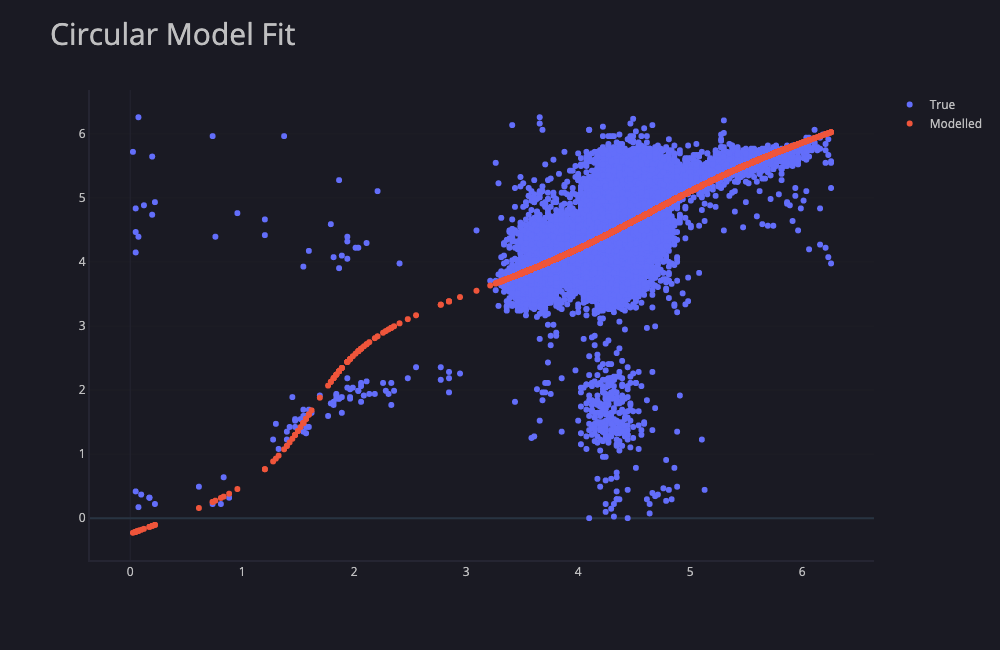

In [483]:
p12 = px.scatter(title='Circular Model Fit')\
    .add_scatter(mode='markers', x=df['RottRad'], y=df['CottRad'], name='True')\
    .add_scatter(mode='markers', x=df['RottRad'], y=y_pred_fit, name='Modelled')
show(theme(p12))

In [489]:
y_pred_scaled = y_pred.apply(remove_origin, scale=True)

In [490]:
time_df = df.assign(y_pred=y_pred_scaled).set_index('DateTime').reindex(index=dt_range)

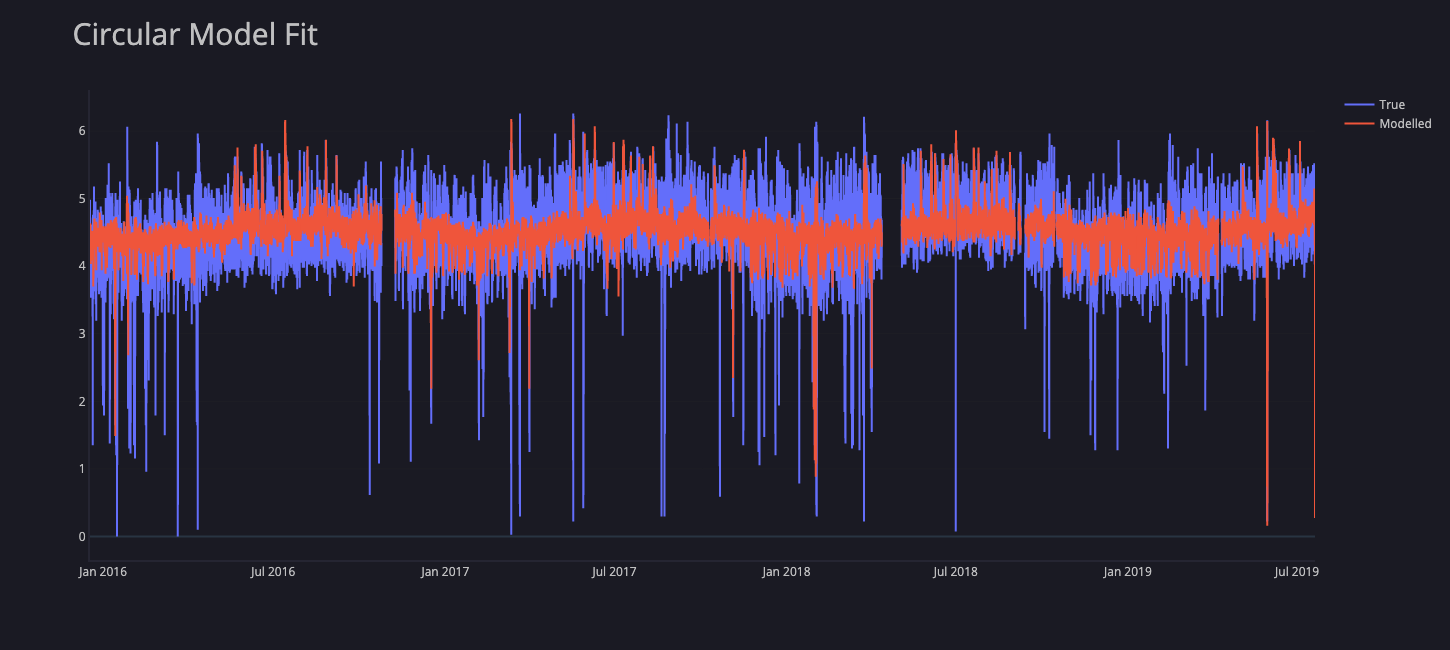

In [492]:
p13 = px.line(title='Circular Model Fit')\
        .add_scatter(mode='lines', x=time_df.index, y=time_df['CottRad'], name='True')\
        .add_scatter(mode='lines', x=time_df.index, y=time_df['y_pred'], name='Modelled')

show(theme(p13), w=1450)

## Comparison with Null model

In [543]:
pred_cmse = cmse(df['CottRad'], y_pred, return_deg=True)
print(f'Null model CMSE:     {round(null_cmse, 4)} deg')
print(f'Circular model CMSE: {round(pred_cmse, 4)} deg')

Null model CMSE:     5.7698 deg
Circular model CMSE: 4.4214 deg


___